# Cell segmentation using CellPose
This notebook segments cells in give FOVs using CellPose. There are two parts:
1. Image processing: all membrane channels are first contrast enhanced and combined. The nulei channel is simplycontrast enhanced. 
2. The processed images are then loaded and subjet to CellPose.

In [1]:
# import requried packages
import tifffile
import os
import cv2
import numpy as np
import seaborn_image as isns
from cellpose import models
from cellpose.io import imread
import matplotlib.pyplot as plt

from skimage.io import imread, imsave

# Define basic info.
## Defining the working directory

In [2]:
base_dir = "../data"
project_name = "SMP2023"
imageData_dir = os.path.join(base_dir, project_name, "image_data")
FOVs = os.listdir(imageData_dir)

In [4]:
FOVs

['2023-03-09-ST0026_set1_B10_Mamm',
 '2023-03-09-ST0026_set1_B2_Skin',
 '2023-03-09-ST0026_set1_C2_Skin',
 '2023-03-09-ST0026_set1_C4_Live',
 '2023-03-09-ST0026_set1_D1_Tons',
 '2023-03-09-ST0026_set2_D7_Mela',
 '2023-03-09-ST0026_set2_F3_Lung',
 '2023-03-09-ST0026_set2_F9_CoCa',
 '2023-03-09-ST0026_set2_G8_LuCa',
 '2023-03-09-ST0026_set2_H2_Skin',
 '2023-03-10-ST0026_set3_D4_Live',
 '2023-03-10-ST0026_set3_F4_Live',
 '2023-03-10-ST0026_set3_G3_Lung',
 '2023-03-10-ST0026_set3_G6_Colo',
 '2023-03-10-ST0026_set3_H5_Brai',
 '2023-03-10-ST0026_set4_B7_Mela',
 '2023-03-10-ST0026_set4_B8_LuCa',
 '2023-03-10-ST0026_set4_F1_Tons',
 '2023-03-10-ST0026_set4_G7_Mela',
 '2023-03-10-ST0026_set4_H9_CoCa',
 '2023-03-10-ST0026_set5_B5_Brai',
 '2023-03-10-ST0026_set5_C9_CoCa',
 '2023-03-10-ST0026_set5_D8_LuCa',
 '2023-03-10-ST0026_set5_G1_Tons',
 '2023-03-10-ST0026_set5_H6_Colo',
 '2023-03-11-ST0026_set6_C5_Brai',
 '2023-03-11-ST0026_set6_H10_Mamm',
 '2023-03-11-ST0026_set6_H3_Lung']

## Defining the membrane channels
These channels will be merged into a new channel *membrane_sum*
- membrane_channels: a list of channel names
- qt: a value between 0 and 1. qt is used to saturate the images. For example, a value of 0.99 will rescale all pixels linearly to make the 99th quantile and above the maximum 

In [5]:
membrane_channels = ['membrane','GLUT1','ASCT2']
qt = 0.9965


KeyboardInterrupt



In [1]:
targetDir = '../cellpose_input'

os.makedirs(targetDir, exist_ok=True)
os.makedirs('../cellpose_output', exist_ok=True)


for oneFOV in FOVs:
    membrane_sum = np.zeros([2048, 2048], dtype = 'uint32')
    folderPath = os.path.join(imageData_dir, oneFOV)
    files = os.listdir(folderPath)

    for ch in membrane_channels:
        img = tifffile.imread(os.path.join(folderPath, ch + '.tiff'))
        q = np.quantile(img,qt)
        img[img > q] = q
        membrane_sum = membrane_sum + img

    q = np.quantile(membrane_sum,qt)
    membrane_sum[membrane_sum > q] = q
    membrane_sum_normalized = cv2.normalize(membrane_sum, None, 0, 255,cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    membrane_sum_normalized = cv2.equalizeHist(membrane_sum_normalized)

    # Change the Nucleus tiff file here if it is named differently
    img = tifffile.imread(os.path.join(folderPath, 'nuclei.tiff'))
    q = np.quantile(img,qt)
    img[img > q] = q
    img_Uint8 = cv2.normalize(img, None, 0, 255,cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    nu_equal = cv2.equalizeHist(img_Uint8)

    os.makedirs(targetDir, exist_ok=True)
    cell = np.stack((nu_equal, membrane_sum_normalized), axis = 0)
    tifffile.imwrite(os.path.join(targetDir, oneFOV + 'membrane_sum_proc.tiff'), membrane_sum_normalized, shape=membrane_sum_normalized.shape)
    tifffile.imwrite(os.path.join(targetDir, oneFOV + 'nuclei_proc.tiff'), nu_equal, shape=nu_equal.shape)
    tifffile.imwrite(os.path.join(targetDir, oneFOV + 'cell.tiff'), cell, shape=cell.shape)

SyntaxError: invalid syntax (457790160.py, line 14)

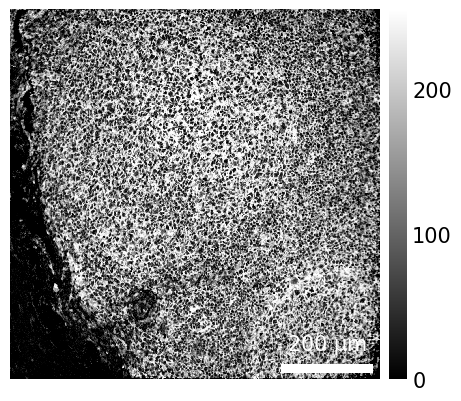

In [6]:
isns.set_context("notebook")
# change image related settings
isns.set_image(cmap="gray", despine=True)  # set the colormap and despine the axes
isns.set_scalebar(color="white")  # change scalebar color
# image with a scalebar

ax = isns.imgplot(membrane_sum_normalized, dx=0.39, units="um")

## Segmentation
>**WARNING: the imsave() part has not been tested!**

The mean cell diameter is a key parameter to optimal segmentation. However, from my experience, the estimated diameter provided by Cellpose is not working well. Therefore, I came up with this idea to minimize the difference between the mean diameter we put and the mean diameter of the final masks. This is currently simply done by trying a couple of different diameters.

### Options for the segmentation
- which_to_segment: a two-element array. The two elements correspond to *whole cell* and *nuclei*
- model_type: a string that corresponds to the pre-trained models Cellpose supplied
- dia: defining the range of diameters to be tested in pixels
- cellprob_threshold: a value between -6 and 6, the smaller the more ROIs you get
- flow_threshold: a value, the higher the more ROIs you get. 0 means keeping all the masks

Check out https://cellpose.readthedocs.io/en/latest/settings.html#settings for more details

In [1]:
which_to_segment = [False, True]
model_type = 'TN2'
dia = range(15,50,5)
cellprob_threshold = -6
flow_threshold = 0

In [8]:
# This is the actual part of the segmentation

# Load the respective models
model = models.CellposeModel(model_type=model_type)
model_nu = models.CellposeModel(model_type='nuclei')

# Looping through all the FOVs
srcDir = '../cellpose_input'
targetDir = '../cellpose_output'
for oneFOV in FOVs:
    
    # reading an image
    imgs = imread(srcDir + '/' + oneFOV + 'cell.tiff')
    
    if which_to_segment[0]:
        nCell = []
        dia_result = []
        masks = []

        # trying a couple of diameters
        for diai in dia:
            
            # segmenting
            mask, flow, style = model.eval(imgs, diameter=diai, channels=[2,1],
                                                 flow_threshold=flow_threshold, cellprob_threshold = cellprob_threshold, do_3D=False)
            mask = np.reshape(mask, [1, 2048, 2048])
            imsave(os.path.join(targetDir, oneFOV + 'whole_cell_dia' + str(diai) + 'px.tiff'), mask, check_contrast=False)

            if len(masks)==0:
                masks = mask
            else:
                masks = np.concatenate((masks, mask), axis = 0)

            cellID, pixels_per_cell = np.unique(mask, return_counts=True)
            pixels_per_cell = pixels_per_cell[1:]
            meanArea = pixels_per_cell.mean()
            r = (meanArea/np.pi)**0.5
            dia_result.append(r*2)
            nCell.append(len(pixels_per_cell))
            
        # take the best match as the final output
        idx_min = np.argmin(np.abs(np.array(dia_result)-np.array(dia)))
        finalMask = masks[idx_min,:]
        finalMask = np.reshape(finalMask,[1,2048,2048])
        imsave(os.path.join(targetDir, oneFOV + '_whole_cell.tiff'), finalMask, check_contrast=False)
        
    if which_to_segment[1]:
        # For nuclei
        mask_nu, flow_nu, style_nu = model_nu.eval(imgs, diameter=15, channels=[1,0],
                                             flow_threshold=0, cellprob_threshold = -6, do_3D=False)
        mask_nu = np.reshape(mask_nu,[1,2048,2048])
        imsave(os.path.join(targetDir, oneFOV + '_nuclear.tiff'), mask_nu, check_contrast=False)